#  Streaming Mode in G-API Python

## Introduction of Streaming Mode

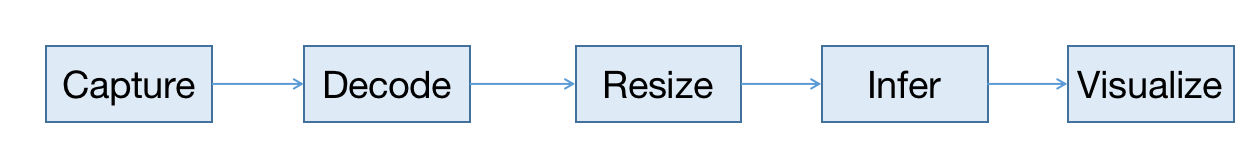

In [3]:
from IPython.display import Image
image_path = '/Users/anna/tutorials-py/resources/streaming1.png'
Image(filename=image_path)

Streaming is a prominent feature of G-API. With the streaming feature, users can shift the execution model of G-API from a regular mode to a streaming mode. In the regular mode, G-API processes an entire image at once, then proceeds to the next one. However, in the streaming mode, G-API processes multiple images consecutively, creating a pipeline of image processing.

The advantage of the Streaming mode is that it can fully utilize system resources and increase processing speed. Under streaming mode, G-API processes images as parallel as possible. For instance, while one image is undergoing the second operation, another image might have already commenced the first operation, enabling efficient use of system resources and improved processing efficiency.

G-API's Streaming mode is especially suitable for dealing with continuous image streams, such as video streams or continuous images captured by cameras. With the streaming mode, users can more easily develop high-performance real-time image processing and computation applications.

## Anatomy of a regular video analytics application

Here's a brief overview of these steps:

**Capture**: This is the first step in any video analytics application. The capture process involves obtaining video data from a source, which can be a physical device such as a camera, a video file, or a network stream.

**Decode**: Video data is usually compressed to save space and bandwidth. The decoding process involves translating this compressed data into a raw format that can be used for further processing. This step is crucial to the workflow because other processes can't start without the raw data.

**Resiz**e: To ensure the computational efficiency of the subsequent steps, the raw video frames are often resized. Depending on the specific analytics task and the computational resources available, video frames might be scaled down (or sometimes up) to a more manageable size.

**Infer**: In the inference step, video frames are inputted into an analytics model. The model processes these frames and makes predictions or "inferences". This could include object detection, activity recognition, scene understanding, etc. The specifics of the inference process depend on the algorithm or model in use.

**Visualize**: After the inference step, the results need to be presented in a human-readable way. This could involve overlaying bounding boxes on objects identified in a frame, displaying statistics about the video, or any other form of visualization that can make the results more understandable.

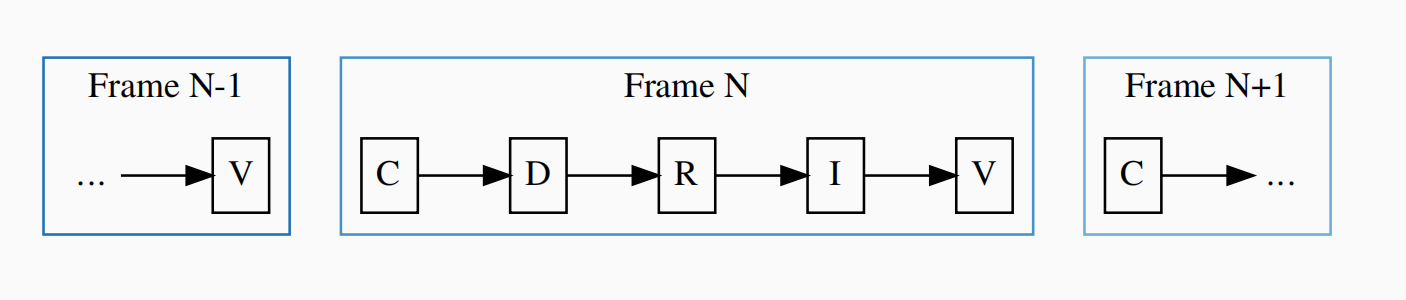

In [4]:
from IPython.display import Image
image_path = '/Users/anna/tutorials-py/resources/streaming2.png'
Image(filename=image_path)

In a serial execution of a sample video analytics application, each frame undergoes a sequence of steps before processing the next frame. The steps, represented by the initial letters, are: Capture (C), Decode (D), Resize (R), Infer (I), and Visualize (V). Here's what the sequence looks like:

* Frame N-1: First, frame N-1 is Captured, then Decoded, then Resized, an Inference is made, and finally, the result is Visualized.

* Frame N: Once the entire sequence for frame N-1 is complete, the same sequence starts for frame N.

* Frame N+1: Similarly, once frame N has been fully processed, the process starts for frame N+1.

In this model, every step of the pipeline for a given frame is completed before moving on to the next frame. This is a simple execution model, and can be effective for some use cases, but it may not take full advantage of all available system resources. Specifically, while one step of the pipeline is being processed, the resources not being used by that step remain idle.

For example, while frame N is being Decoded (a CPU-intensive task), the GPU might be idle. Then, when the Infer step (which is typically GPU-intensive) is running, the CPU might be idle. This is one of the motivations behind the development of more complex execution models, like Streaming in G-API, that aim to use resources more efficiently by overlapping the processing of different frames and different stages of the pipeline.